In [768]:
import pandas as pd
import seaborn as sbn
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score as ss

In [769]:
df = pd.read_csv("ds_salaries.csv")
"""
Beberapa Notes untuk Kolom dataset tersebut adalah: 
1. work_year: Tahun dimana gajinya telah diberikan
2. experience_level: level experience / pengalaman dalam bidang pekerjaan
    field_value: {
        EN: Entry level                 1
        MI: Junior Mid Level            2
        SE: Intermediate Senior Level   3
        EX: Expert Executive Level      4
    }
3. employement_type: Tipe pekerja
    field_value: {
        PT: kerja paruh waktu           4
        FT: kerja fulltime              3
        CT: contract                    2
        FL: Freelance                   1
}
4. job_title: Job Title
5. salary: nilai gaji
6. salary_currency: nilai gaji tersebut dalam mata uang apa
7. salary_in_usd: gaji jika di ubah menjadi mata uang dollar
8. employee_residence: lokasi asal dari pekerja
9. remote_ratio: rasio pekerja bekerja secara jarak jauh
10. company_location: lokasi perusahaan pekerja
11. company_size: ukuran dari perusahaan berdasarkan dari jumlah pekerja di sana
    field_value{
        S: small (x<50),
        M: medium (50<=x<250),
        L: large (x>250),
}
"""


df = pd.read_csv("ds_salaries.csv")
df

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,1
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,1
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,1
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,1
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M,1
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M,1
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M,1
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M,1


Menghapus Outlier

In [770]:

q1 = df["salary_in_usd"].quantile(0.25) # Quartile 1
q3 = df["salary_in_usd"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary_in_usd"])):
    if hi_lim < df["salary_in_usd"][i]:
        df = df.drop([i])

df = df.reset_index()

q1 = df["salary"].quantile(0.25) # Quartile 1
q3 = df["salary"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary"])):
    if hi_lim < df["salary"][i]:
        df = df.drop([i])
df = df.reset_index()

df["company_size"] = df["company_size"].apply(lambda x: 1 if x == "S" else x)
df["company_size"] = df["company_size"].apply(lambda x: 2 if x == "M" else x)
df["company_size"] = df["company_size"].apply(lambda x: 3 if x == "L" else x)



df["experience_level"] = df["experience_level"].apply(lambda x: 1 if x == "EN" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 2 if x == "MI" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 3 if x == "SE" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 4 if x == "EX" else x)

df["employment_type"] = df["employment_type"].apply(lambda x: 4 if x == "FT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 3 if x == "PT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 2 if x == "CT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 1 if x == "FL" else x)

-68185.0, 280911.0
-65002.5, 295001.5


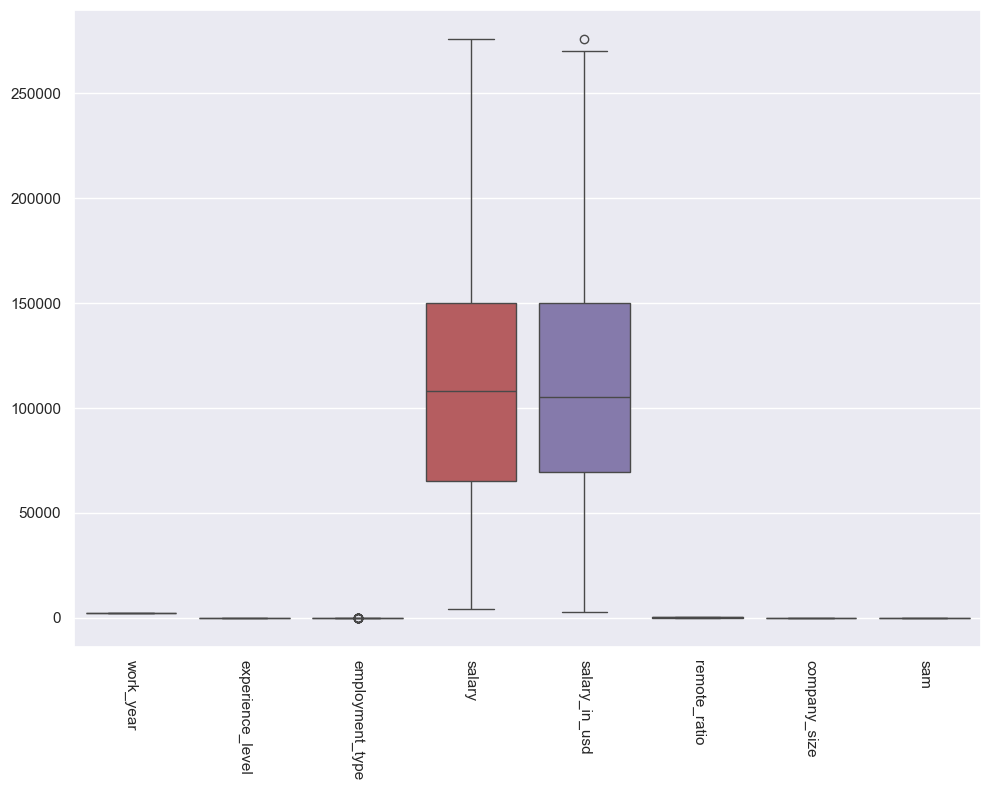

In [771]:
df = df.drop(columns=["level_0", "index", "Unnamed: 0"])
ax = sbn.boxplot(data=df)
ax.tick_params(axis="x", rotation=270)

# Visualisasi

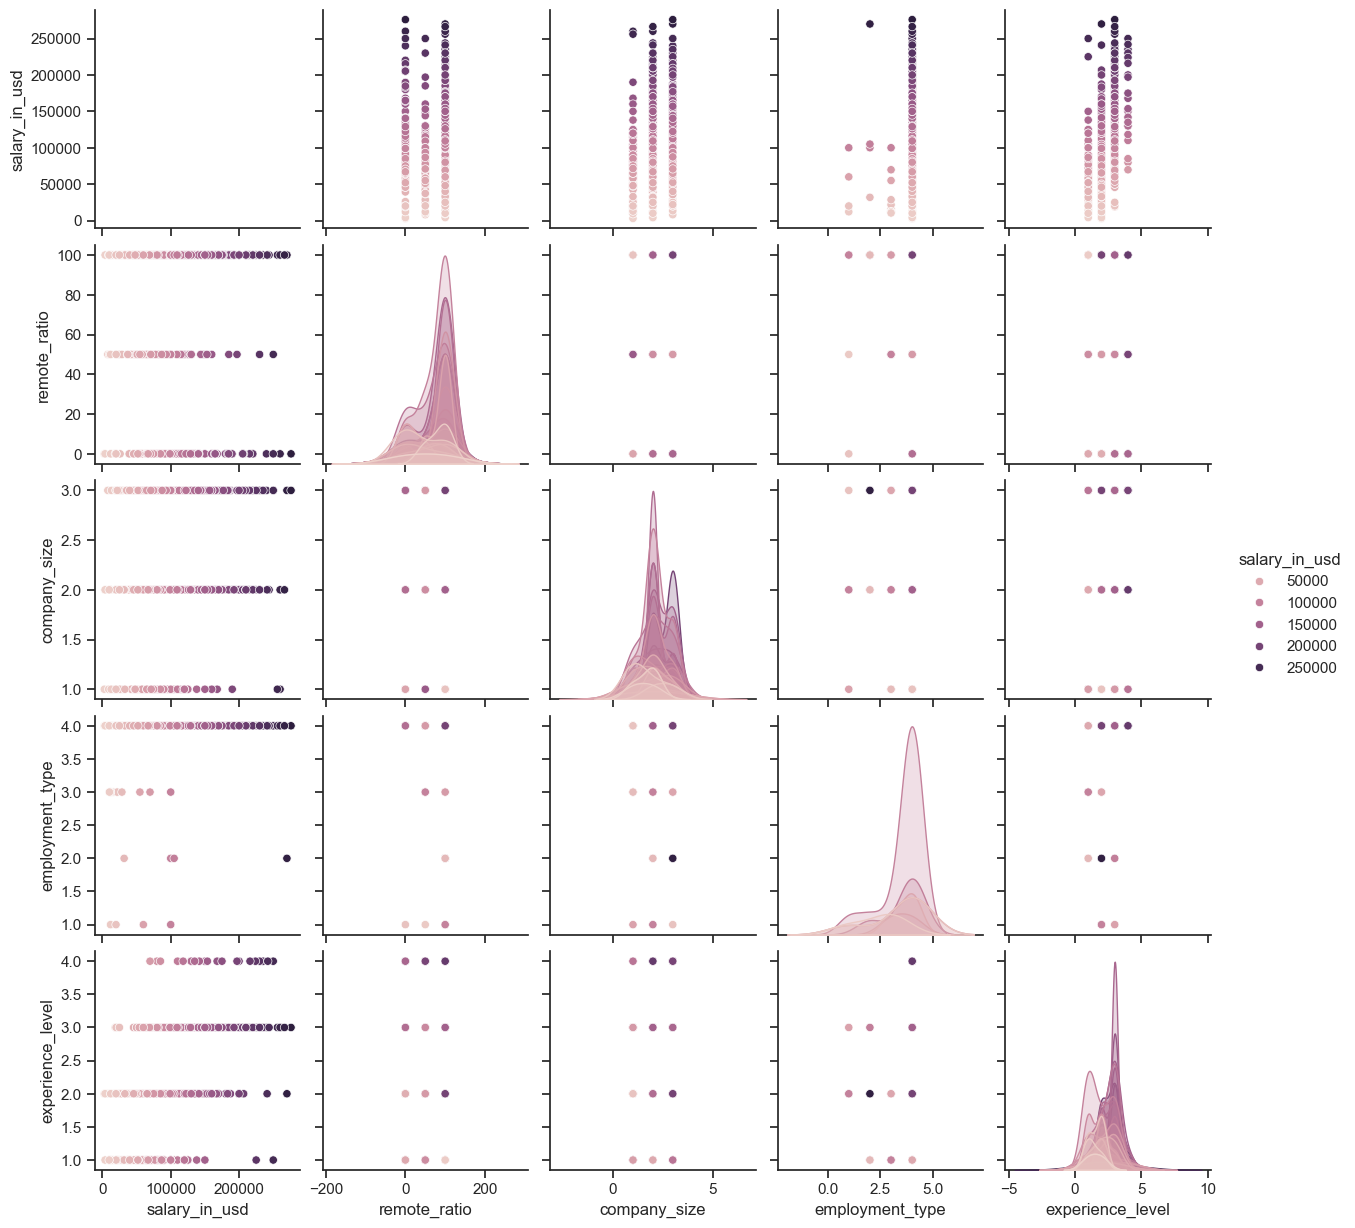

In [772]:
sbn.set(style='ticks', color_codes=True)
sbn.pairplot(df, vars=["salary_in_usd", "remote_ratio", "company_size", "employment_type", "experience_level"], hue='salary_in_usd')

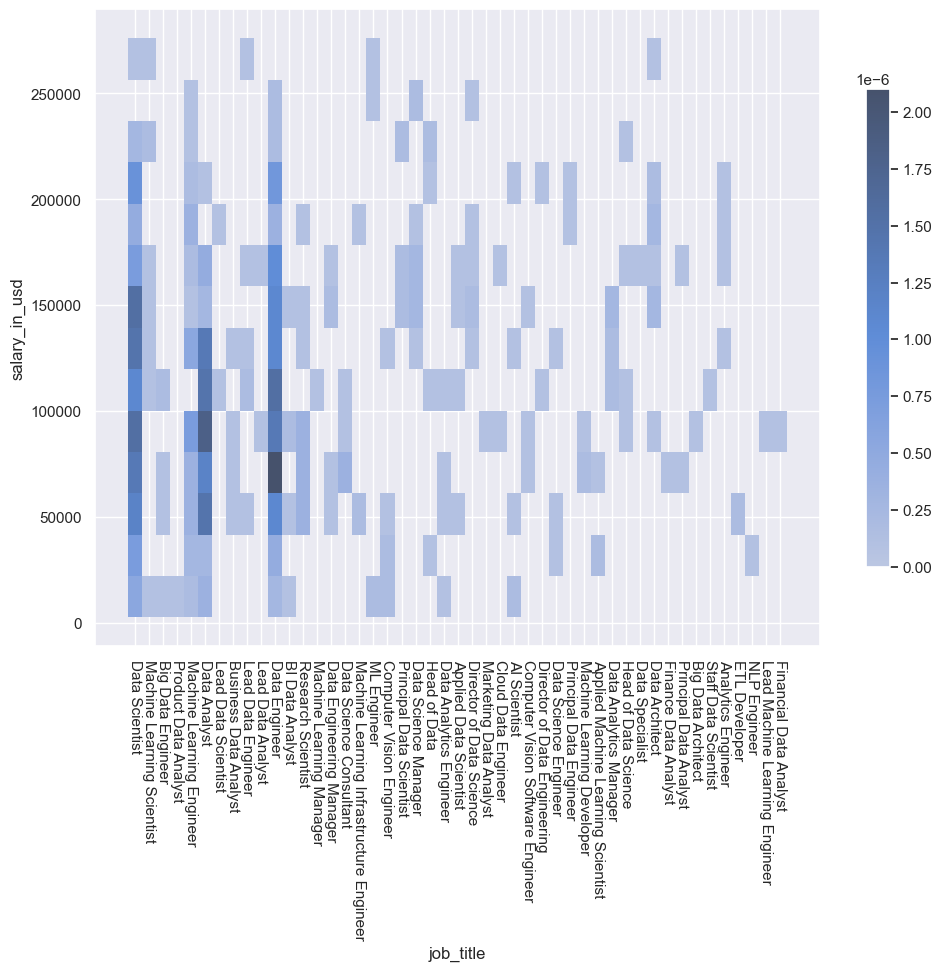

In [773]:
sbn.set(rc={'figure.figsize':(11.7,8.27)})
ax = sbn.histplot(df, x= df["job_title"], y=df["salary_in_usd"], multiple="stack", element="step", stat="density", common_norm=False, cbar=True, cbar_kws=dict(shrink=.75))
ax.tick_params(axis="x", rotation=270)

# Korelasi

In [774]:
# Mengubah kategorikal menjadi numerik
jub = pd.DataFrame(df["job_title"])
num_now = 1
literal = {}
go_get_job = []

for i in range(len(df["job_title"])):
    if df["job_title"][i] not in go_get_job:
        go_get_job.append(df["job_title"][i])
        literal[df["job_title"][i]] = num_now
        df.loc[i, "job_title"] = num_now
        num_now += 1
    else:
        df.loc[i, "job_title"] = literal[df["job_title"][i]]

#pd.DataFrame(literal, index=[0])
jub

,job_title
0,Data Scientist
1,Machine Learning Scientist
2,Big Data Engineer
3,Product Data Analyst
4,Machine Learning Engineer
...,...
556,Data Engineer
557,Data Engineer
558,Data Analyst
559,Data Analyst


In [775]:
num_now = 1
literal = {}
go_get_job = []

for i in range(len(df["employee_residence"])):
    if df["employee_residence"][i] not in go_get_job:
        go_get_job.append(df["employee_residence"][i])
        literal[df["employee_residence"][i]] = num_now
        df.loc[i, "employee_residence"] = num_now 
        num_now += 1
    else:
        df.loc[i, "employee_residence"] = literal[df["employee_residence"][i]]

pd.DataFrame(literal, index=[0])

,DE,JP,GB,HN,US,NZ,FR,PK,PL,PT,...,CZ,AR,DZ,TN,MY,EE,AU,BO,IE,CH
0,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54


In [776]:
num_now = 1
literal = {}
go_get_job = []

for i in range(len(df["company_location"])):
    if df["company_location"][i] not in go_get_job:
        go_get_job.append(df["company_location"][i])
        literal[df["company_location"][i]] = num_now
        df.loc[i, "company_location"] = num_now
        num_now += 1
    else:
        df.loc[i, "company_location"] = literal[df["company_location"][i]]
pd.DataFrame(literal, index=[0])

,DE,JP,GB,HN,US,NZ,FR,PK,GR,AE,...,VN,TR,CN,CZ,DZ,EE,MY,AU,IE,CH
0,1,2,3,4,5,6,7,8,9,10,...,38,39,40,41,42,43,44,45,46,47


In [777]:
df=df.drop(columns=['salary_currency', 'sam', 'salary'])
df

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,2,4,1,79833,1,0,1,3
1,2020,3,4,2,260000,2,0,2,1
2,2020,3,4,3,109024,3,50,3,2
3,2020,2,4,4,20000,4,0,4,1
4,2020,3,4,5,150000,5,50,5,3
...,...,...,...,...,...,...,...,...,...
556,2022,3,4,11,154000,5,100,5,2
557,2022,3,4,11,126000,5,100,5,2
558,2022,3,4,6,129000,5,0,5,2
559,2022,3,4,6,150000,5,100,5,2


In [778]:
corel = df.corr(method='pearson')
corel

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
work_year,1.000000,0.290400,0.104580,0.011200,0.221019,-0.085472,0.044268,-0.067657,-0.095730
experience_level,0.290400,1.000000,0.130077,0.137003,0.510130,-0.167450,0.090588,-0.177773,0.045014
employment_type,0.104580,0.130077,1.000000,-0.058358,0.128281,-0.125260,-0.016747,-0.047104,0.027727
job_title,0.011200,0.137003,-0.058358,1.000000,0.114896,0.069573,0.069447,0.020959,0.074053
salary_in_usd,0.221019,0.510130,0.128281,0.114896,1.000000,-0.320105,0.120899,-0.323392,0.144224
employee_residence,-0.085472,-0.167450,-0.125260,0.069573,-0.320105,1.000000,0.011539,0.799406,-0.081463
remote_ratio,0.044268,0.090588,-0.016747,0.069447,0.120899,0.011539,1.000000,-0.027185,-0.032959
company_location,-0.067657,-0.177773,-0.047104,0.020959,-0.323392,0.799406,-0.027185,1.000000,0.002805
company_size,-0.095730,0.045014,0.027727,0.074053,0.144224,-0.081463,-0.032959,0.002805,1.000000


<Axes: >

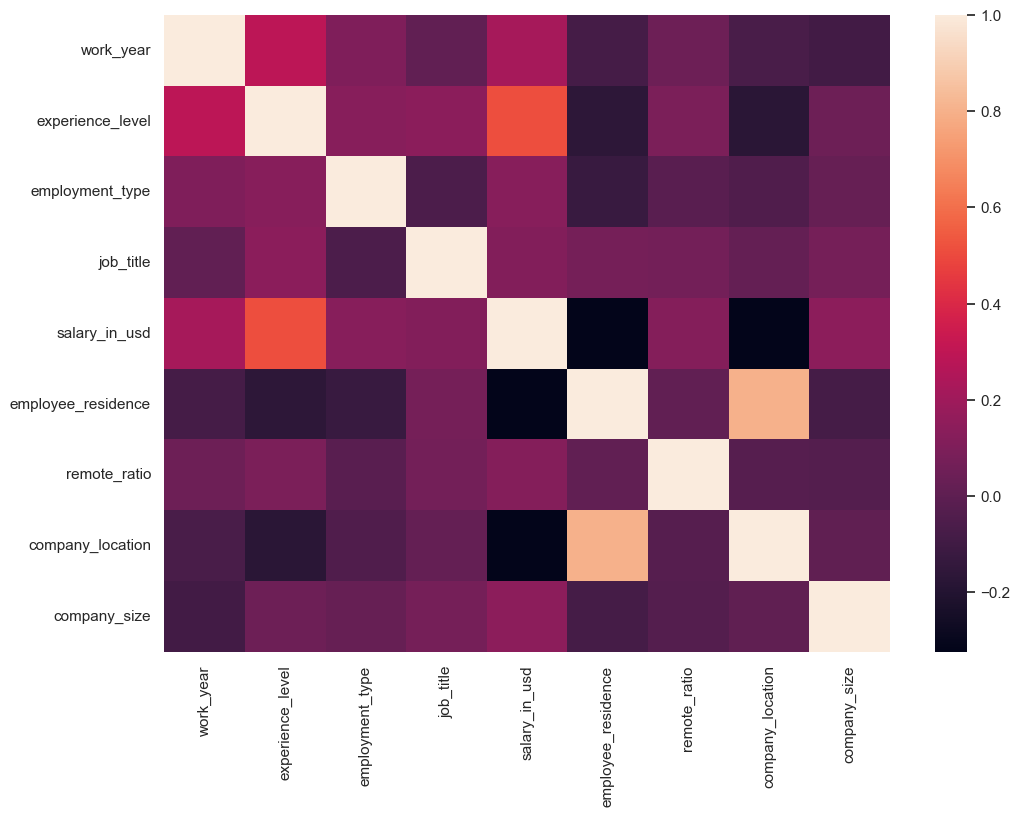

In [779]:
sbn.heatmap(corel, xticklabels=corel.columns, yticklabels=corel.columns)

# Clustering

In [780]:
X = np.array(df[["employment_type", "work_year"]])
y = np.array(df["salary_in_usd"]).reshape(-1, 1)
X

array([[   4, 2020],
       [   4, 2020],
       [   4, 2020],
       ...,
       [   4, 2022],
       [   4, 2022],
       [   4, 2022]], dtype=int64)

In [781]:
dbss = DBSCAN(eps=0.2, min_samples=50).fit(X)

In [782]:
df['cluster'] = dbss.labels_
df

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,cluster
0,2020,2,4,1,79833,1,0,1,3,0
1,2020,3,4,2,260000,2,0,2,1,0
2,2020,3,4,3,109024,3,50,3,2,0
3,2020,2,4,4,20000,4,0,4,1,0
4,2020,3,4,5,150000,5,50,5,3,0
...,...,...,...,...,...,...,...,...,...,...
556,2022,3,4,11,154000,5,100,5,2,2
557,2022,3,4,11,126000,5,100,5,2,2
558,2022,3,4,6,129000,5,0,5,2,2
559,2022,3,4,6,150000,5,100,5,2,2


In [783]:
ss(X, df['cluster'])

0.9720518631411279

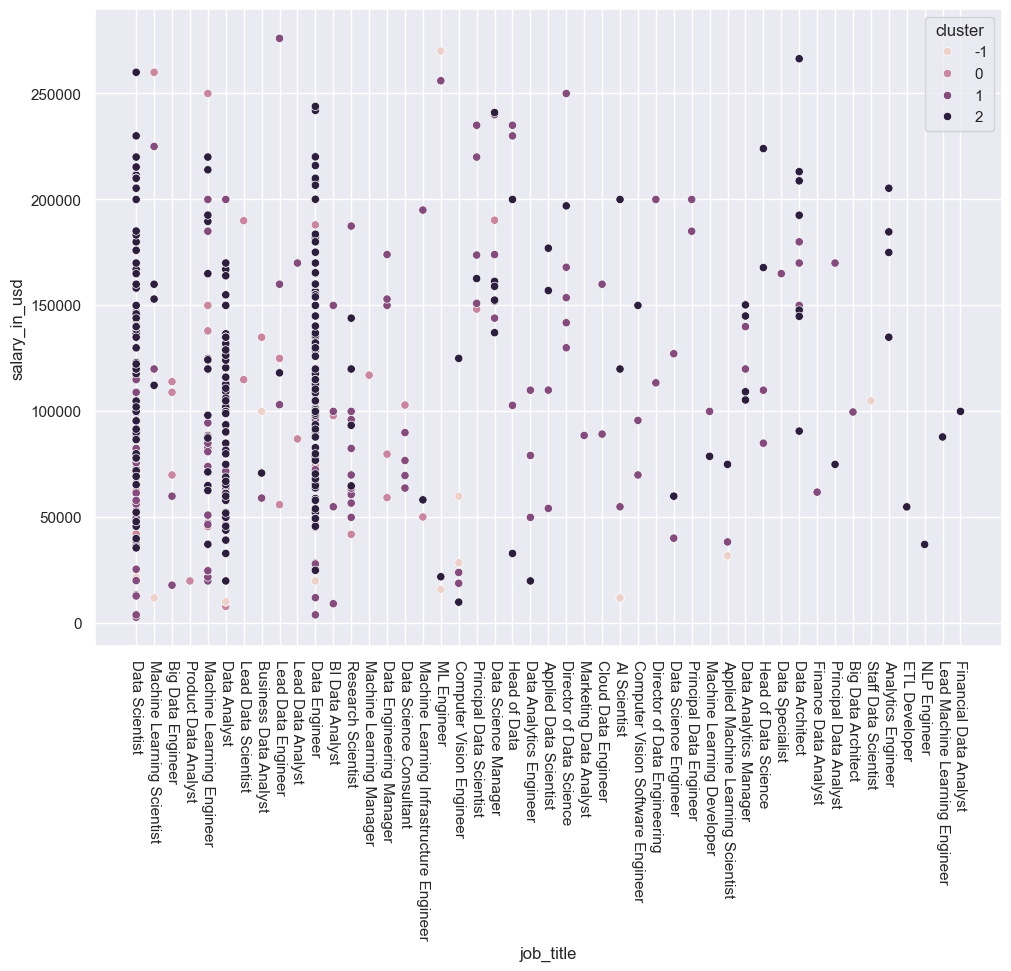

In [784]:
g = sbn.scatterplot(df, x=jub['job_title'], y=df["salary_in_usd"], hue=df["cluster"])
g.tick_params(axis="x", rotation=270)